<a href="https://colab.research.google.com/github/limshaocong/analyticsEdge/blob/main/Data_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
# In case any of the packages can't load
# install.packages("janitor")

library(tidyverse) # generic must have package
library(ggplot2) # plotting package
library(janitor) # quick data exploration
library(lubridate) # easy comprehension of dates from string to datetime

options(repr.plot.width = 9,
        repr.plot.height = 6,
        repr.plot.pointsize = 20)

In [5]:
# Accessing all the files stored on the GitHub repository
#
# As Colab is primarily designed for Python, the proper way to integrate
# GitHub and Colab within the workflow doesn't work very well when we force
# Colab to run in R.
# 
# Hence, I'm using this method that is untidy but very stable

path = "https://raw.githubusercontent.com/limshaocong/analyticsEdge/main/Datasets/"

# Russell 3000 tickers
tickers.path = paste0(path,"r3000_tickers.csv")

# Quiver Quant data
twitter.follower.path = paste0(path, "QuiverQuant/twitter_follower.csv")
wiki.pageviews.path = paste0(path,"QuiverQuant/wikipedia_pageviews.csv")
wsb.sentiment.path = paste0(path,"QuiverQuant/wsb_sentiment.csv")
otc.path = paste0(path,"QuiverQuant/otc_2019.csv")

# RavenPack Sentiment Relevance data
rp.company.index.path = paste0(path,"RavenPack_WRDS/rp_company_index.csv")
## Dow Jones new releases (2018-2021)
rp.dj.2018.path = paste0(path,"RavenPack_WRDS/rp_dj_2018.csv")
rp.dj.2019.path = paste0(path,"RavenPack_WRDS/rp_dj_2019.csv")
rp.dj.2020.path = paste0(path,"RavenPack_WRDS/rp_dj_2020.csv")
rp.dj.2021.path = paste0(path,"RavenPack_WRDS/rp_dj_2021.csv")
## Global Press releases (2018-2021)
rp.pr.2018.path = paste0(path,"RavenPack_WRDS/rp_pr_2018.csv")
rp.pr.2019.path = paste0(path,"RavenPack_WRDS/rp_pr_2019.csv")
rp.pr.2020.path = paste0(path,"RavenPack_WRDS/rp_pr_2020.csv")
rp.pr.2021.path = paste0(path,"RavenPack_WRDS/rp_pr_2021.csv")

# CRSP Stock Price data
crsp.permnocode.path = paste0(path,"CRSP_WRDS/crsp_permno.csv")
crsp.price.2019.path = paste0(path,"CRSP_WRDS/crsp_daily_stock_price_2019.csv")
crsp.price.2020.path = paste0(path,"CRSP_WRDS/crsp_daily_stock_price_2020.csv")
crsp.price.2021.path = paste0(path,"CRSP_WRDS/crsp_daily_stock_price_2021.csv")

#**Scope of Analysis**


*   Russell 3000 stocks



In [14]:
# Stocks of Concern
# Import all R3000 tickers
tickers = read.csv(tickers.path)

# Of concern are 2958 stocks
length(unique(tickers$Ticker))

[1] 2958

# **RavenPack Data**


* Index File file for Ravenpack Indentifier
*   Dow Jones News Release Sentiment (2018-2021)
* Global Press Release Sentiment (2018-2021)



In [10]:
# Import company index which allows the tickers to be mapped to RavenPack's
# internal entity index (rp_entity_id)
rp.company.index = read.csv(rp.company.index.path)

# Read the 2021 Dow Jones sentiment data
rp.dj.2021 = read.csv(rp.dj.2021.path)
# Convert to datetime format
rp.dj.2021$rpna_date_utc = mdy(rp.dj.2021$rpna_date_utc)

**Dow Jones + Global Press Release Sentiment**

*   Generally sparse data requires imputation
* Significant volume of ess = 50
*   Retaining relevance = 100 is sufficient, relevance = 20 can be omitted
* Should consider scaling due to odd range



In [11]:
# Sample of RavenPack Identifier dataset
#
# $rp_entitiy_id is the identifier for RavenPack data
# Our primary identified is $ticker

head(rp.company.index, 5)

,X,rp_entity_id,entity_type,entity_name,ticker,cusip,isin,country
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,7,00067A,COMP,Humana Inc.,HUM,444859102,US4448591028,US
2,88,001F1B,COMP,PriceSmart Inc.,PSMT,741511109,US7415111092,US
3,120,002A99,COMP,FibroGen Inc.,FGEN,31572Q808,US31572Q8087,US
4,143,00326D,COMP,Park Aerospace Corp.,PKE,70014A104,US70014A1043,US
5,144,00326E,COMP,Meritor Inc.,MTOR,59001K100,US59001K1007,US


In [12]:
# Sample of RavenPack Dow Jones dataset
# Sumamrises sentiment data by Dow Jones-affliated publications
#
# $rp_entitiy_id: identifier
# $ess: event sentiment score bounded [0-100], 50 = neutral, >50 = positive, <50 = negative
# $relevance: if the company is the topic of the publication, 100 = sole focus of the release, 1 = mentioned in passing

head(rp.dj.2021, 5)

,rp_entity_id,category,relevance,ess,rpna_date_utc
,<chr>,<chr>,<int>,<int>,<date>
1,036C6F,legal-issues-defendant,100,22,2021-01-01
2,315EB0,insider-gift,100,57,2021-01-01
3,579E8F,ownership-decrease-held,100,49,2021-01-01
4,693ECD,insider-surrender,100,37,2021-01-01
5,723548,dividend,100,50,2021-01-01


In [16]:
# Only 2815/2958 stocks have any press release in 2021 dataset

length(unique(rp.dj.2021$rp_entity_id))

[1] 2815

In [17]:
# Sample of Stock level data - APPL
#
# Conclusions:
#
# 1. Data is relatively spares, with no data on most dates. Preprocess to
# fill in non-entries. (see intervals between dates)
#
# 2. There are several entries which share the same "category", "relevance",
# "ess" and "date". Preprocess to aggregate repetitions. (see rows 3-5)
#
# 3. There are also several entries on the same "date" that have a range of 
# "ess". Need to determine means of aggregation. (see Jan 6, row 8-10)
#

aapl.index = rp.company.index$rp_entity_id[rp.company.index$ticker == "AAPL"]

rp.dj.2021 %>%
  filter(rp.dj.2021$rp_entity_id == aapl.index) %>%
  head(25)

,rp_entity_id,category,relevance,ess,rpna_date_utc
,<chr>,<chr>,<int>,<int>,<date>
1,D8442A,analyst-ratings-change-neutral,100,51,2021-01-05
2,D8442A,price-target-upgrade,100,91,2021-01-05
3,D8442A,executive-appointment,100,54,2021-01-05
4,D8442A,executive-appointment,100,54,2021-01-05
5,D8442A,executive-appointment,100,54,2021-01-05
6,D8442A,analyst-ratings-change-neutral,100,78,2021-01-05
7,D8442A,price-target-upgrade,100,75,2021-01-05
8,D8442A,executive-salary-increase,100,44,2021-01-06
9,D8442A,executive-salary-increase,100,44,2021-01-06


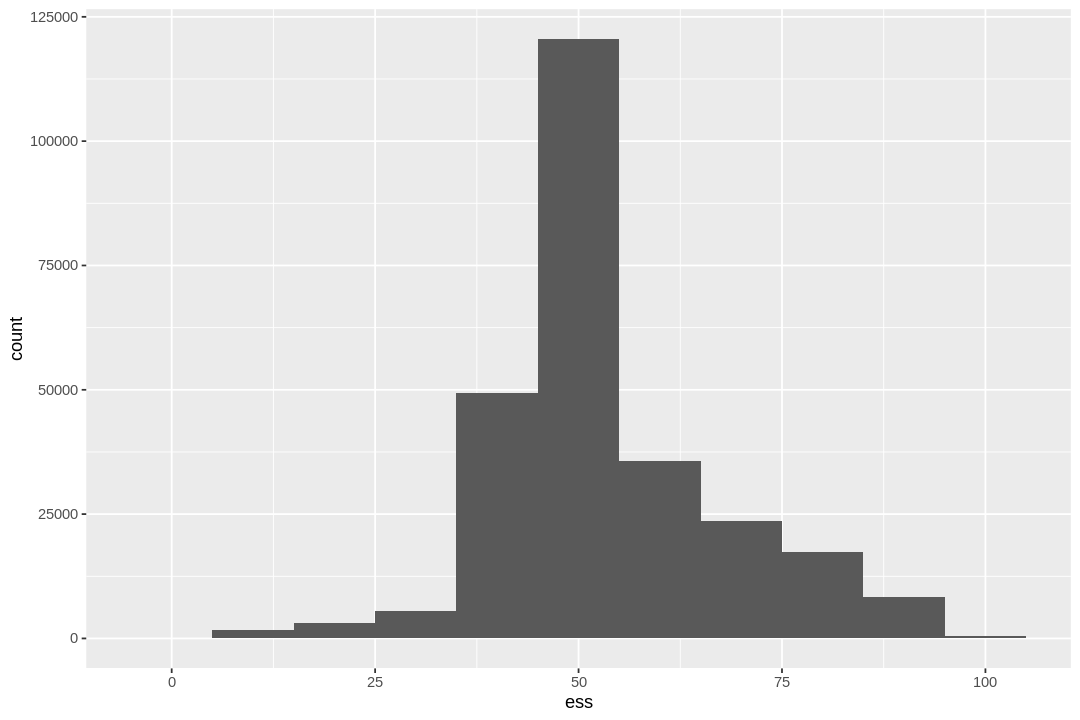

In [27]:
# Plotting relative frequency of $ess

ggplot(data = rp.dj.2021) +
  geom_histogram(aes(x = ess), binwidth = 10)

In [33]:
# Following from the above, it is clear that majority of news release are neutral
# with a longer bias towards positive news
#
# Conclusion:
#
# 4. Many entries that have neutral sentiment (ie. ess = 50). Preprocessing
# needs to assume if absence of press release and neutral announcement should
# encoded the same.

rp.dj.2021 %>%
  tabyl(ess) %>%
  adorn_pct_formatting(digits = 2, affix_sign = TRUE) %>%
  arrange(desc(n)) %>% head(10)

,ess,n,percent
,<int>,<dbl>,<chr>
1,50,100179,37.67%
2,40,28903,10.87%
3,61,19855,7.47%
4,69,16805,6.32%
5,37,15529,5.84%
6,78,10144,3.81%
7,54,8050,3.03%
8,63,5770,2.17%
9,51,4329,1.63%


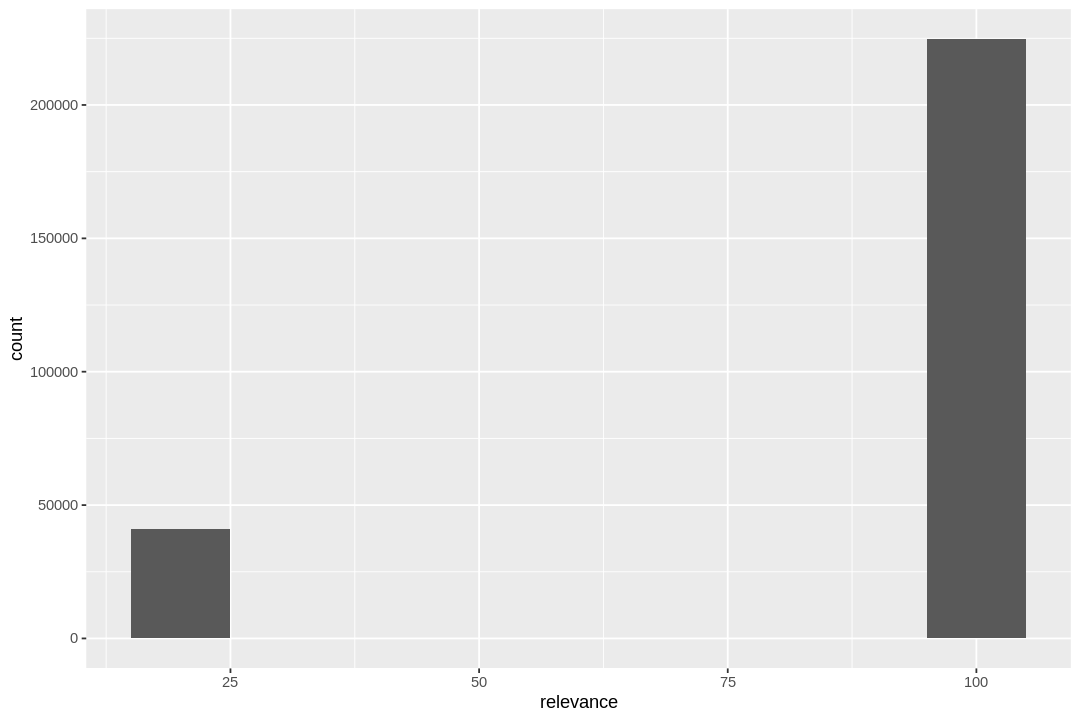

In [37]:
# Plotting relative frequency of $ess
# It is striking that the data is essentially categorical

ggplot(data = rp.dj.2021) +
  geom_histogram(aes(x = relevance), binwidth = 10)

In [42]:
# Assess the prevelance across various stocks
rp.dj.2021 %>%
  filter(relevance == 20) %>%
  tabyl(rp_entity_id) %>%
  adorn_pct_formatting(digits = 2, affix_sign = TRUE) %>%
  arrange(desc(n)) %>%
  head(10)

,rp_entity_id,n,percent
,<chr>,<dbl>,<chr>
1,CFF97C,8494,20.62%
2,9196A2,6849,16.62%
3,3461CF,6038,14.65%
4,B3CB74,5185,12.58%
5,1E1125,2918,7.08%
6,619882,2468,5.99%
7,58CA9A,2139,5.19%
8,E8846E,1737,4.22%
9,50070E,1592,3.86%


In [54]:
# Assess the trend where relevance = 20 is heavily concentrated across a few stocks
#
# Conclusion:
# 4. Relevance = 20 should be eliminiated as they largely pertain to their role
# in publishing credit rating or price target changes

# Top 5 stocks
curious = c("CFF97C", "9196A2", "3461CF", "B3CB74", "1E1125")
rp.company.index %>%
  filter(rp_entity_id %in% curious)

# Top categories
rp.dj.2021 %>%
  filter(relevance == 20) %>%
  tabyl(category) %>%
  adorn_pct_formatting(digits = 2, affix_sign = TRUE) %>%
  arrange(desc(n)) %>%
  head(5)

X,rp_entity_id,entity_type,entity_name,ticker,cusip,isin,country
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
19746,1E1125,COMP,Credit Suisse Group AG,CSR,225401108,US2254011081,US
32754,3461CF,COMP,Moody's Corp.,MCO,615369105,US6153691059,US
89182,9196A2,COMP,Morgan Stanley & Co. LLC,MS,617446448,US6174464486,US
108932,B3CB74,COMP,Raymond James Financial Inc.,RJF,754730109,US7547301090,US
126416,CFF97C,COMP,S&P Global Inc.,SPGI,78409V104,US78409V1044,US


,category,n,percent
,<chr>,<dbl>,<chr>
1,analyst-ratings-change-neutral-rater,8221,19.95%
2,price-target-upgrade-rater,7846,19.04%
3,credit-rating-action-rater,3914,9.50%
4,price-target-downgrade-rater,2866,6.96%
5,credit-rating-set-rater,2671,6.48%


**Exploring Twitter Follower Data**

In [ ]:
twitter.follower = read.csv(twitter.follower.path)
twitter.follower$Date <- ymd(twitter.follower$Date)

In [ ]:
head(twitter.follower, 10)

,Date,Ticker,Followers,pct_change_day,pct_change_week,pct_change_month
,<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,2021-10-14,A,28378,0.000000000,0.08111444,0.4495416
2,2021-10-13,A,28378,0.014097413,0.06699813,0.4673228
3,2021-10-12,A,28374,0.003524477,0.09877937,0.4673890
4,2021-10-11,A,28373,0.010574551,0.11291062,0.4602910
5,2021-10-09,A,28370,0.014101389,0.10585745,0.4816887
6,2021-10-08,A,28366,0.021156558,0.10587239,0.4781977
7,2021-10-07,A,28360,0.017633574,0.09529524,0.4533862
8,2021-10-06,A,28355,-0.014104870,0.10591350,0.4605846
9,2021-10-05,A,28359,0.045861850,0.09883167,0.4676374


In [ ]:
first = min(twitter.follower$Date)
last = max(twitter.follower$Date)
last - first
paste(first, ",", last)
length(unique(twitter.follower$Ticker))

Time difference of 530 days

[1] "2020-05-02 , 2021-10-14"

[1] 1411

**Exploring r/wsb Data**

In [ ]:
wsb.sentiment = read.csv(wsb.sentiment.path)
wsb.sentiment$Date <- ymd(wsb.sentiment$Date)

In [ ]:
head(wsb.sentiment, 10)

,Date,Ticker,Mentions,Rank,Sentiment
,<date>,<chr>,<int>,<int>,<dbl>
1,2018-08-10,AA,1,53,-0.4019
2,2018-08-28,AA,1,60,0.2023
3,2018-09-07,AA,1,74,0.7184
4,2018-10-09,AA,1,84,-0.2732
5,2018-10-18,AA,1,90,-0.0516
6,2018-11-03,AA,2,36,-0.0772
7,2018-11-28,AA,1,119,-0.5267
8,2019-01-04,AA,1,144,-0.5859
9,2019-01-08,AA,1,105,0.2732


In [ ]:
first = min(wsb.sentiment$Date)
last = max(wsb.sentiment$Date)
last - first
paste(first, ",", last)
length(unique(wsb.sentiment$Ticker))

Time difference of 1177 days

[1] "2018-08-01 , 2021-10-21"

[1] 1251

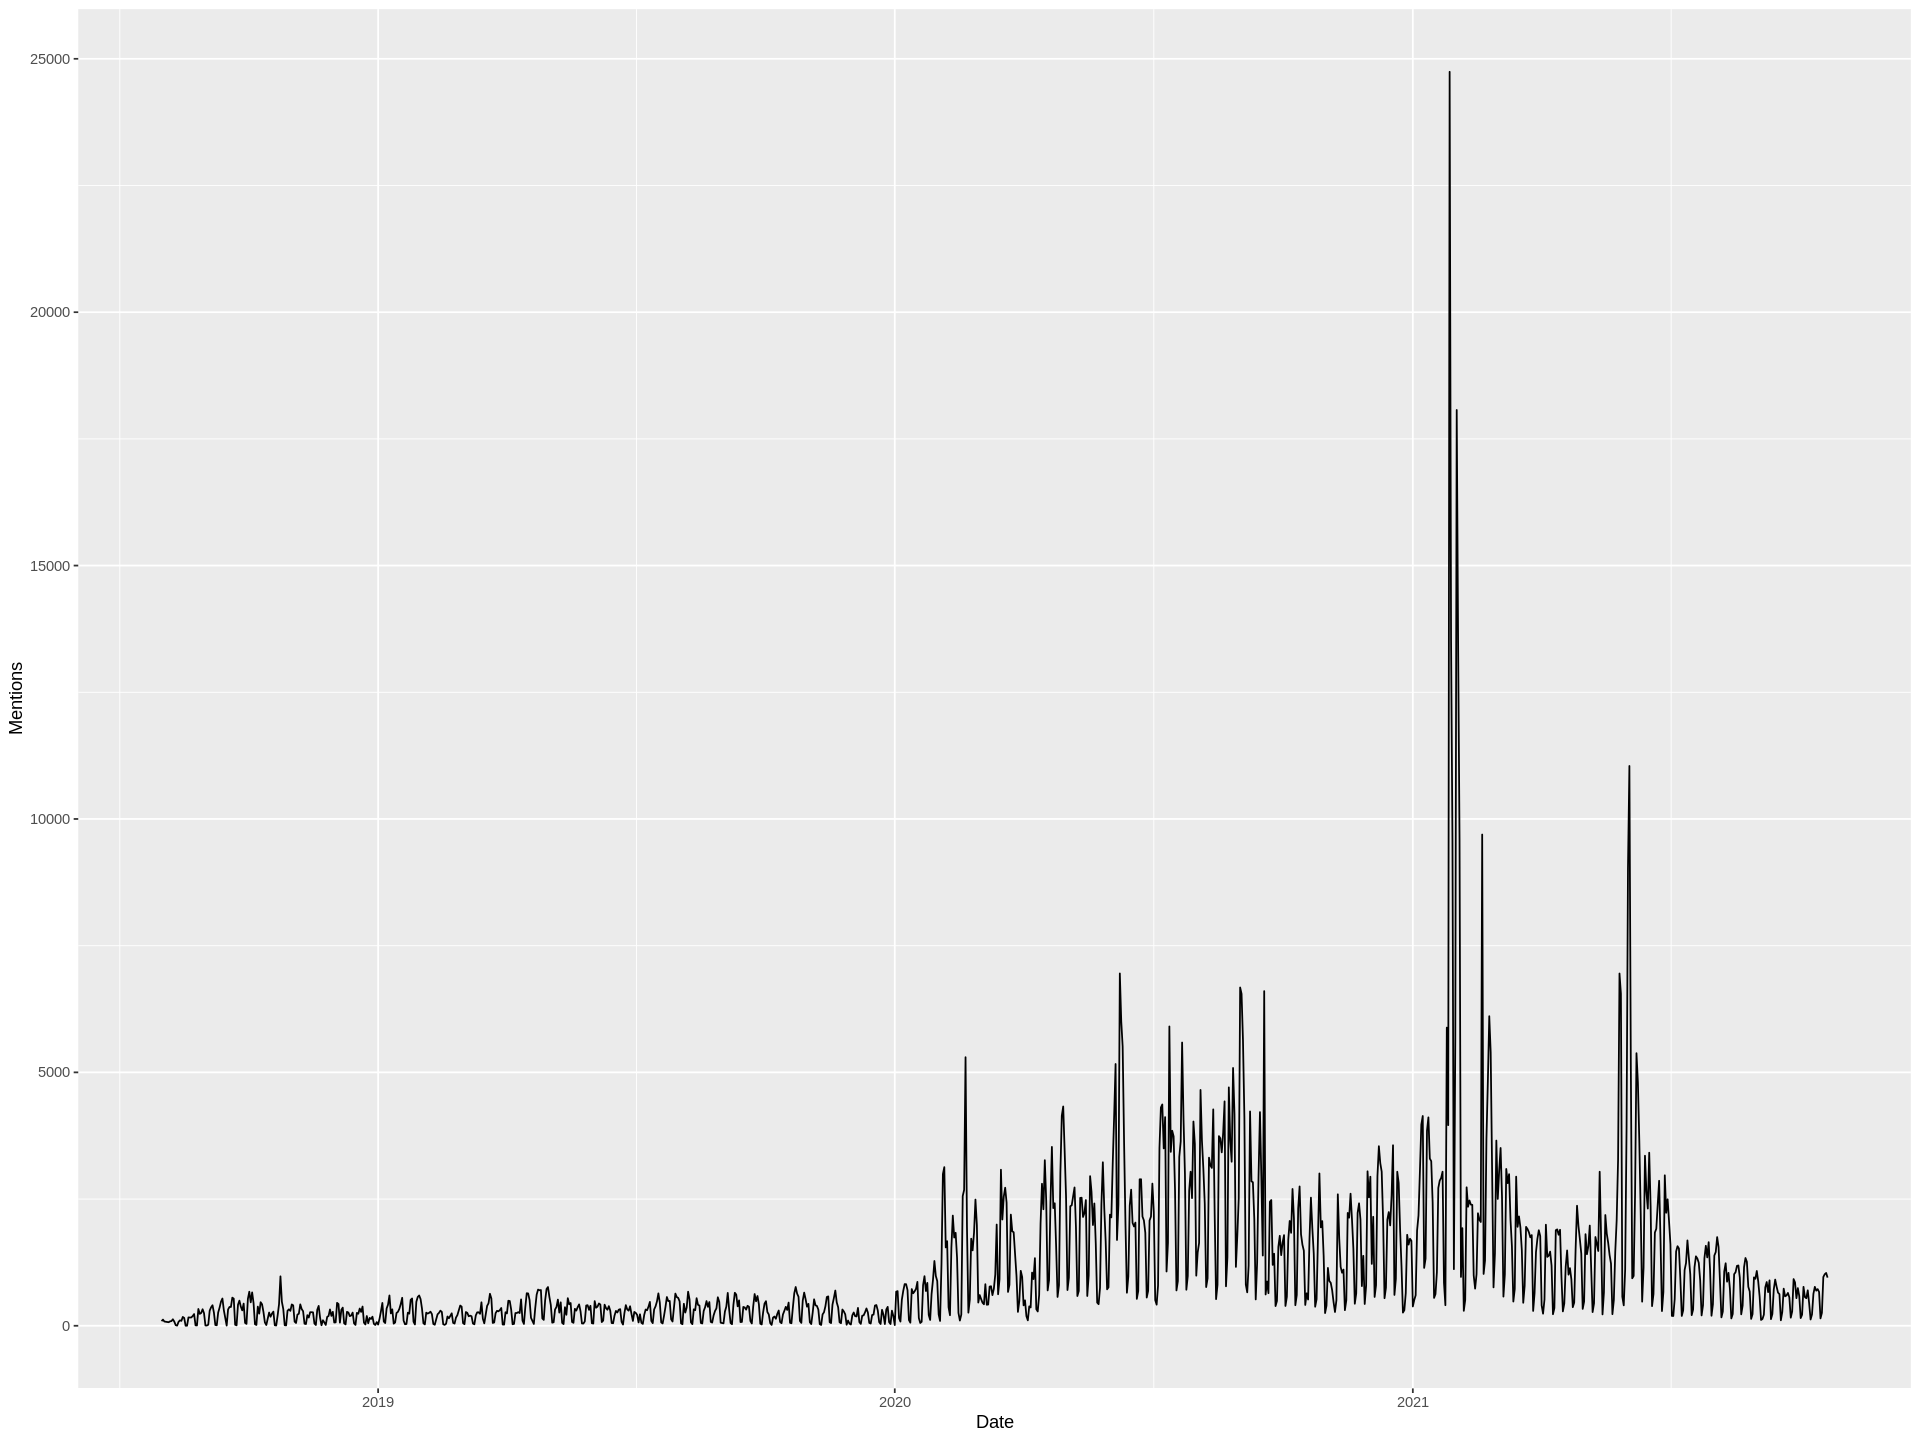

In [ ]:
mentions.time <- aggregate(Mentions ~ Date, data = wsb.sentiment, FUN = sum)
options(repr.plot.width = 12, repr.plot.height = 6)
ggplot(mentions.time, aes(x = Date, y = Mentions)) + geom_line()

**Explore wikipedia pageviews**

In [ ]:
wiki.pageviews = read.csv(wiki.pageviews.path)
wiki.pageviews$Date <- ymd(wiki.pageviews$Date)

In [ ]:
head(wiki.pageviews, 10)

,Date,Ticker,Views,pct_change_week,pct_change_month
,<date>,<chr>,<dbl>,<dbl>,<dbl>
1,2016-10-17,A,66,-34.848485,-31.818182
2,2016-10-24,A,43,-34.848485,-31.818182
3,2016-10-31,A,52,20.930233,-31.818182
4,2016-11-07,A,47,-9.615385,-31.818182
5,2016-11-14,A,45,-4.255319,-31.818182
6,2016-11-21,A,44,-2.222222,2.325581
7,2016-11-28,A,36,-18.181818,-30.769231
8,2016-12-05,A,54,50.000000,14.893617
9,2016-12-12,A,55,1.851852,22.222222


In [ ]:
first = min(wiki.pageviews$Date)
last = max(wiki.pageviews$Date)
last - first
paste(first, ",", last)
length(unique(wiki.pageviews$Ticker))

Time difference of 1820 days

[1] "2016-10-17 , 2021-10-11"

[1] 954

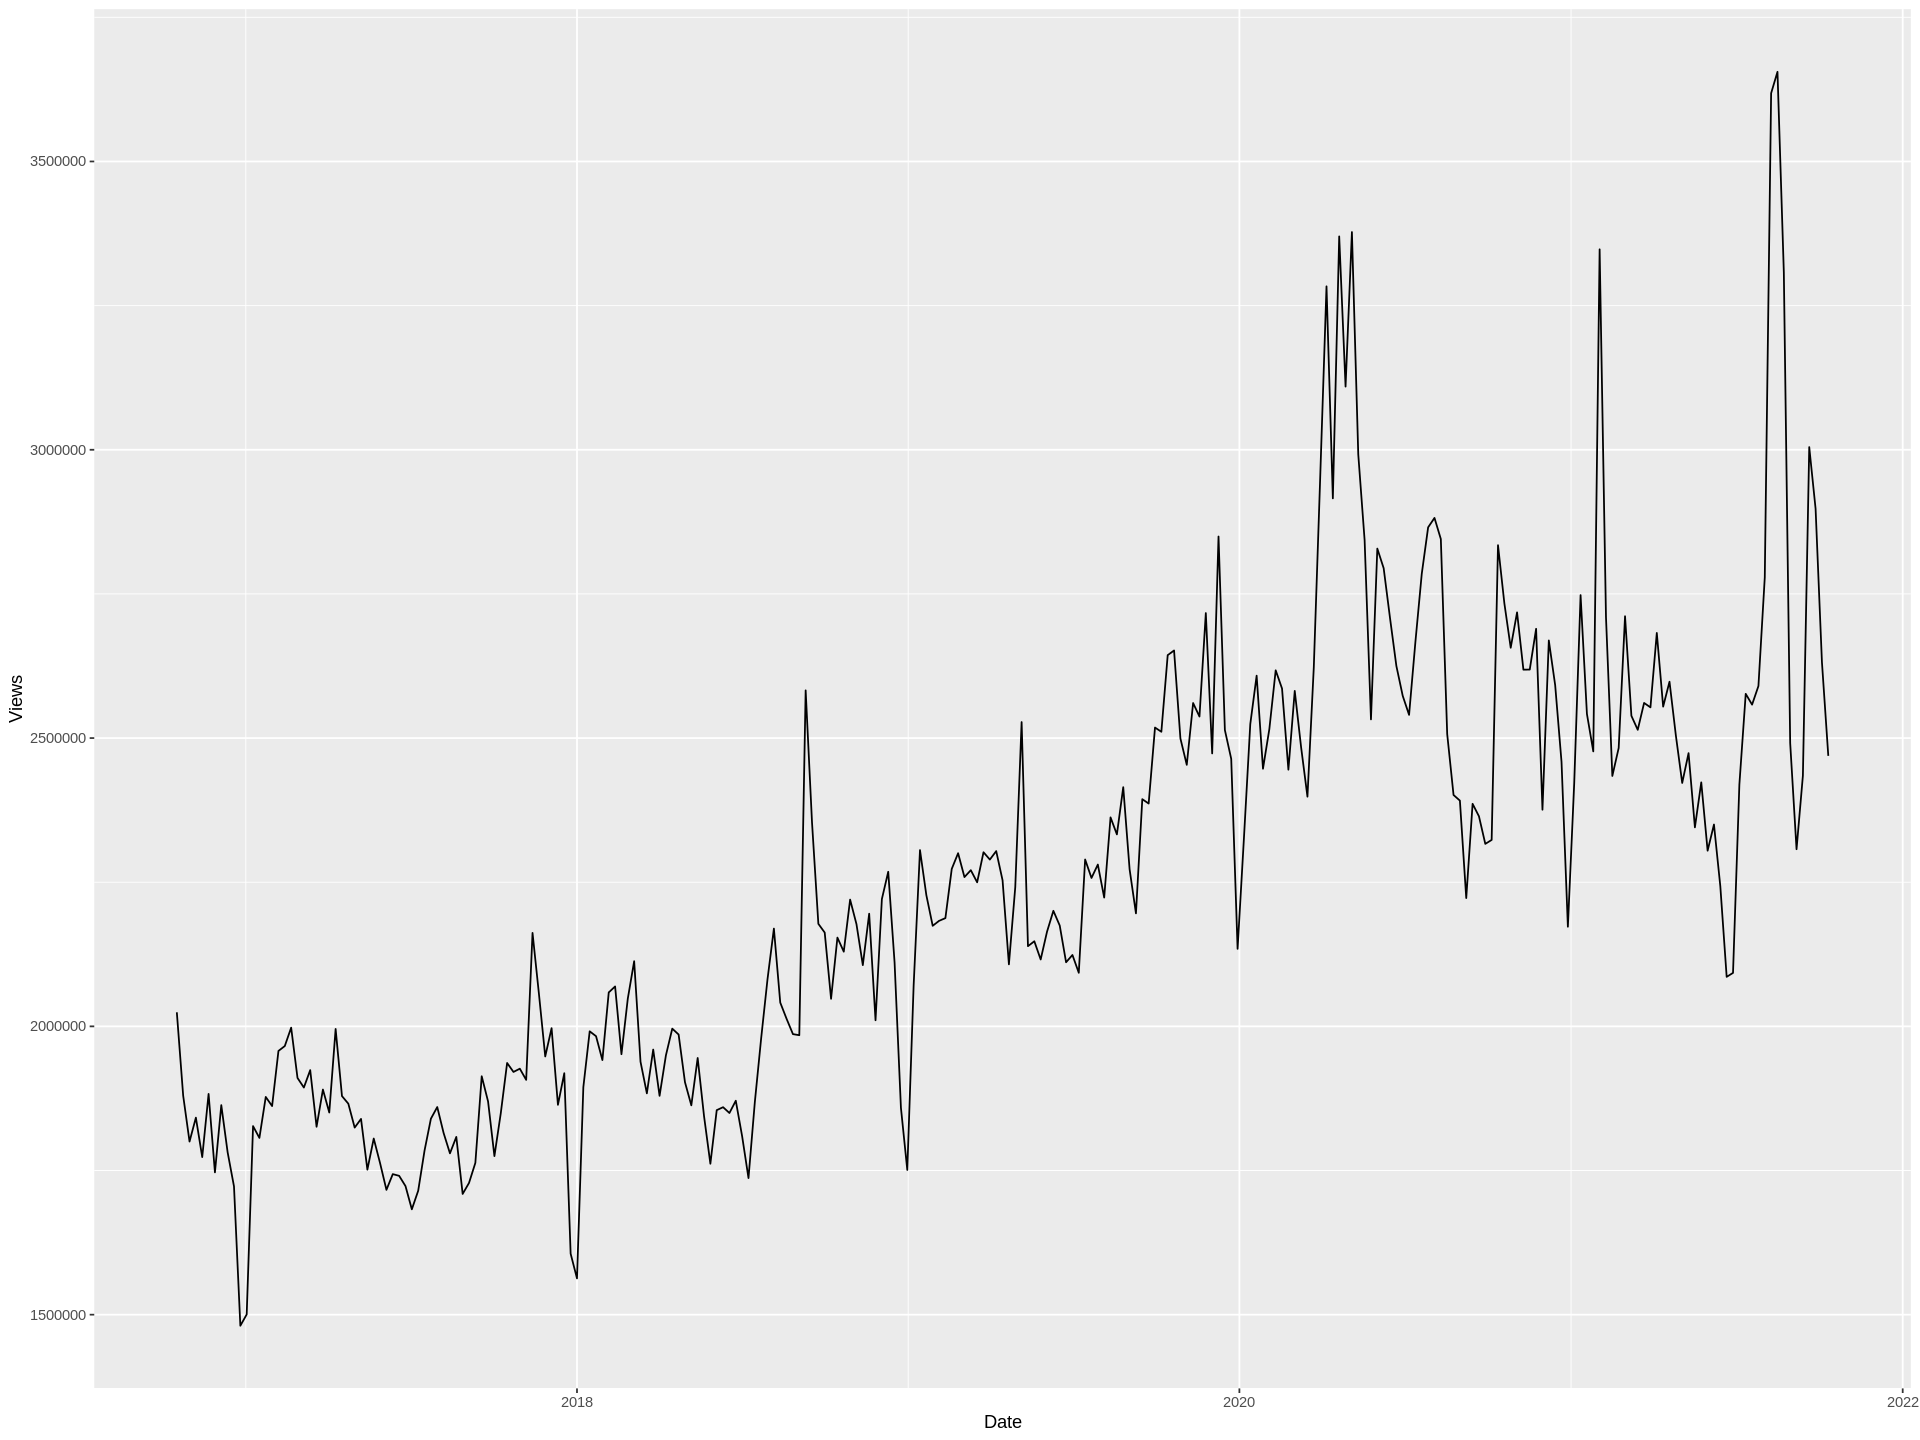

In [ ]:
views.time <- aggregate(Views ~ Date, data = wiki.pageviews, FUN = sum)
options(repr.plot.width = 16, repr.plot.height = 12)
ggplot(views.time, aes(x = Date, y = Views)) + geom_line()

**Explore OTC data**

In [ ]:
otc = read.csv(otc.path)
otc$Date <- ymd(otc$Date)

In [ ]:
first = min(otc$Date)
last = max(otc$Date)
last - first
paste(first, ",", last)
length(unique(otc$Ticker))

Time difference of 1023 days

[1] "2019-01-02 , 2021-10-21"

[1] 2734

**Stock Price History**

In [ ]:
crsp.permnocode = read.csv(crsp.permnocode.path)
crsp.price.2020 = read.csv(crsp.price.2020.path)

In [ ]:
crsp.price.2020$date <- dmy(crsp.price.2020$date)
head(crsp.price.2020, 5)

,PERMNO,date,CUSIP,BIDLO,ASKHI,PRC,VOL,BID,ASK,OPENPRC,NUMTRD
,<int>,<date>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,10026,2020-01-02,46603210,181.440,185.30,181.68,88291,181.67,181.70,185.30,2300
2,10026,2020-01-03,46603210,180.890,185.17,184.91,71463,184.90,184.91,180.89,1572
3,10026,2020-01-06,46603210,183.140,185.52,185.07,70308,184.77,185.07,184.18,1764
4,10026,2020-01-07,46603210,182.475,184.63,183.03,72267,182.90,183.22,184.40,2032
5,10026,2020-01-08,46603210,181.810,183.89,182.04,118592,182.04,182.23,182.73,2208
